In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tqdm import tqdm
import pandas as pd
import time
import math
from scipy import signal
from scipy.spatial import distance

In [ ]:
image_dir = '1327317/training_set/training_set'
# Read images and store filenames
image_data = []
filenames = []
target_size = (800, 540)  # Consistent size for all images

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        # Read image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to target size
        image = cv2.resize(image, target_size)
        # Append data to lists
        image_data.append(image)
        filenames.append(filename)

# Convert lists to NumPy arrays
image_data = np.array(image_data)  # No need for dtype=object since all images are the same size now

# Verify the shapes of the image_data
print("Image Data Shape:", image_data.shape)

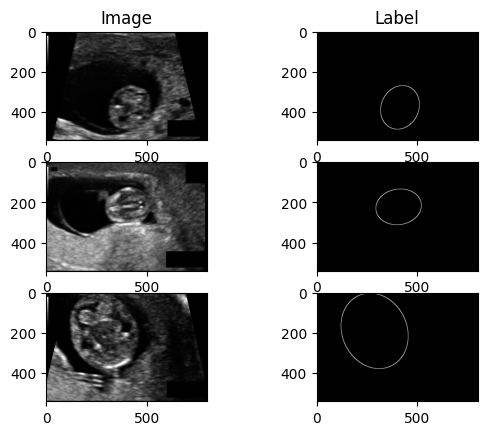

In [3]:
#create labels and image sets
X = image_data[::2]
Y = image_data[1::2]
#show some datapoints of training set
fig ,ax = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        if(j%2==0):
            ax[i][j].imshow(X[i],cmap='gray')
            if i==0:
                ax[i][j].set_title("Image")
        if(j%2!=0):
            ax[i][j].imshow(Y[i],cmap='gray')
            if i==0:
                ax[i][j].set_title("Label")

In [4]:
#resize the images and labels
IMG_CHANNELS = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128
X_resize = np.zeros((999,IMG_HEIGHT,IMG_WIDTH))
Y_resize = np.zeros((999,IMG_HEIGHT,IMG_WIDTH))

for i in range(999):
    X_resize[i] = cv2.resize(X[i],(128,128))
    Y_resize[i] = cv2.resize(Y[i],(128,128))

In [ ]:
#split dataset into training and test sets 4:1
X_train, X_test, Y_train, Y_test = train_test_split(X_resize,Y_resize,test_size=0.2, random_state=4,shuffle=True)

In [6]:
# Create a function for a convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",kernel_initializer="he_normal", padding="same")(x)
    return x

# Create a function for the expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [7]:
# Inputs
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [8]:
# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25)

In [ ]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_binary = preds_test_t.squeeze()

Text(0.5, 1.0, 'Predicted Label')

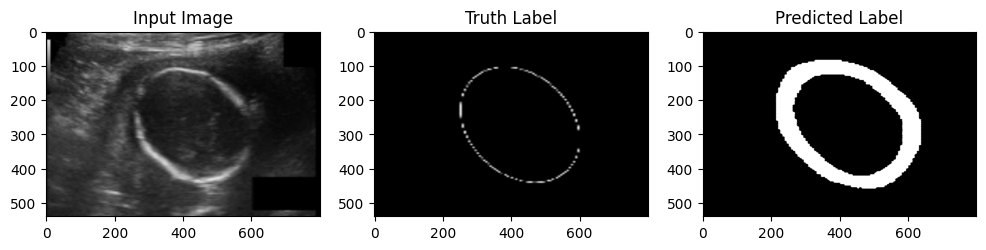

In [11]:
# Select a random index from test set
ix = random.randint(0, len(preds_test_t))

fig ,ax = plt.subplots(1,3,figsize=(12,6))
# Display the input image
ax[0].imshow(cv2.resize(X_test[ix],(800,540)),cmap='gray')
ax[0].set_title("Input Image")

# Display the ground truth label
ax[1].imshow(cv2.resize(Y_test[ix],(800,540)),cmap='gray')
ax[1].set_title("Truth Label")

# Display the predicted lebel
ax[2].imshow(cv2.resize(np.squeeze(preds_test_t[ix]),(800,540)),cmap='gray')
ax[2].set_title("Predicted Label")

In [ ]:
print("pred_test shape:", preds_test_binary.shape)
print("y_test shape:", Y_test.shape)
print("pred_test range:", preds_test_binary.min(), preds_test.max())
print("y_test range:", Y_test.min(), Y_test.max())
y_test_binary = (Y_test > 0).astype(np.uint8)

In [63]:
pred_flat = preds_test_binary.flatten()
y_flat = y_test_binary.flatten()

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

dice = dice_coefficient(y_flat, pred_flat)
print(f"Dice Coefficient: {dice:.4f}")

# IoU (Jaccard Score)
from sklearn.metrics import jaccard_score
iou = jaccard_score(y_flat, pred_flat, average='binary')
print(f"IoU (Jaccard): {iou:.4f}")

# Pixel-wise Accuracy
accuracy = np.mean(pred_flat == y_flat)
print(f"Pixel Accuracy: {accuracy:.4f}")

Dice Coefficient: 0.1468
IoU (Jaccard): 0.0792
Pixel Accuracy: 0.8725


MAE (HC in mm): 253.89 mm
MRE (HC in mm): 2526.51%


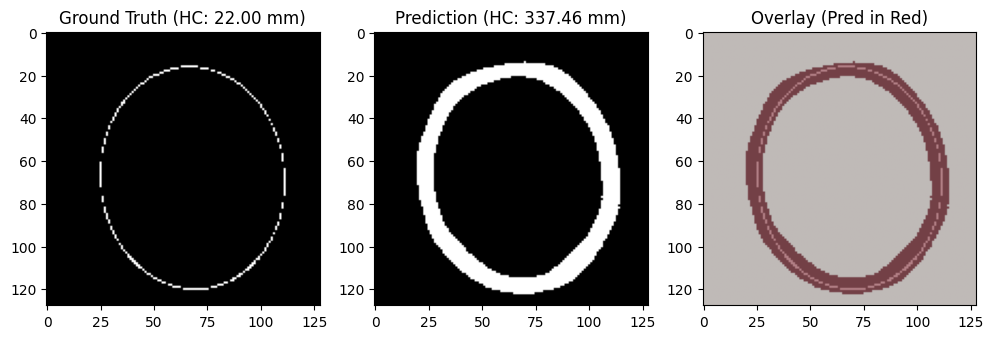

In [67]:
import cv2

def compute_circumference(mask):
    mask = mask.squeeze().astype(np.uint8)  # Ensure the mask is binary and 2D
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        return cv2.arcLength(contours[0], closed=True)  # Assumes the largest contour is the head
    return 0

# Compute HC in pixels (mm) for ground truth and predictions
hc_true_mm = [compute_circumference(y_test_binary[i]) for i in range(len(y_test_binary))]
hc_pred_mm = [compute_circumference(preds_test_binary[i]) for i in range(len(preds_test_binary))]

# Convert to NumPy arrays
hc_true_mm = np.array(hc_true_mm)
hc_pred_mm = np.array(hc_pred_mm)
# Mean Absolute Error (MAE) in mm
mae_hc = np.mean(np.abs(hc_pred_mm - hc_true_mm))

# Mean Relative Error (MRE) in percentage
mre_hc = np.mean([abs(pred - true) / true * 100 if true > 0 else 0 for pred, true in zip(hc_pred_mm, hc_true_mm)])

print(f"MAE (HC in mm): {mae_hc:.2f} mm")
print(f"MRE (HC in mm): {mre_hc:.2f}%")
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Ground Truth (HC: {hc_true_mm[1]:.2f} mm)")
plt.imshow(y_test_binary[1], cmap='gray')
plt.subplot(1, 3, 2)
plt.title(f"Prediction (HC: {hc_pred_mm[1]:.2f} mm)")
plt.imshow(preds_test_binary[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Overlay (Pred in Red)")
plt.imshow(y_test_binary[1], cmap='gray', alpha=0.5)
plt.imshow(preds_test_binary[1], cmap='Reds', alpha=0.5)
plt.show()